## Recomendación por filtrado colabarativo

## Ejercicio

Crear un sistema de recomendaciones para los datos de **last.fm**

In [1]:
import os
import sys
import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T

from plotnine import *

In [2]:
conf = (

    SparkConf()
    .setAppName(u"Sistemas de Recomendación")
    .set("spark.executor.memory", "4g")
    .set("spark.executor.cores", "2")
    .set("spark.default.parallelism", "800")
    .set("spark.sql.shuffle.partitions", "800")

)

In [3]:
spark = (

    SparkSession.builder
    .config(conf=conf)
    .enableHiveSupport()
    .getOrCreate()

)

22/06/05 15:32:29 WARN Utils: Your hostname, mdsuser resolves to a loopback address: 127.0.1.1; using 192.168.229.128 instead (on interface ens33)
22/06/05 15:32:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/05 15:32:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
!head ../datos/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv 

00000c289a1829a808ac09c00daf10bc3c4e223b	3bd73256-3905-4f3a-97e2-8b341527f805	betty blowtorch	2137
00000c289a1829a808ac09c00daf10bc3c4e223b	f2fb0ff0-5679-42ec-a55c-15109ce6e320	die Ärzte	1099
00000c289a1829a808ac09c00daf10bc3c4e223b	b3ae82c2-e60b-4551-a76d-6620f1b456aa	melissa etheridge	897
00000c289a1829a808ac09c00daf10bc3c4e223b	3d6bbeb7-f90e-4d10-b440-e153c0d10b53	elvenking	717
00000c289a1829a808ac09c00daf10bc3c4e223b	bbd2ffd7-17f4-4506-8572-c1ea58c3f9a8	juliette & the licks	706
00000c289a1829a808ac09c00daf10bc3c4e223b	8bfac288-ccc5-448d-9573-c33ea2aa5c30	red hot chili peppers	691
00000c289a1829a808ac09c00daf10bc3c4e223b	6531c8b1-76ea-4141-b270-eb1ac5b41375	magica	545
00000c289a1829a808ac09c00daf10bc3c4e223b	21f3573f-10cf-44b3-aeaa-26cccd8448b5	the black dahlia murder	507
00000c289a1829a808ac09c00daf10bc3c4e223b	c5db90c4-580d-4f33-b364-fbaa5a3a58b5	the murmurs	424
00000c289a1829a808ac09c00daf10bc3c4e223b	0639533a-0402-40ba-b6e0-18b067198b73	lunachicks	403


In [5]:
esquema = T.StructType([

    T.StructField('user_id',T.StringType(),True),
    T.StructField('artist_id',T.StringType(),True),
    T.StructField('artist_name',T.StringType(),True),
    T.StructField('plays',T.DoubleType(),True)

])

In [6]:
plays = (

    spark.read
    .csv('../datos/lastfm-dataset-360K/usersha1-artmbid-artname-plays.tsv', schema=esquema, sep='\t')
    .na.drop()

)

#### Pistas y consejos

Para agilizar el proceso, podemos usar una versión "pequeña" que se os facilita:

In [7]:
plays = spark.read.parquet('../datos/lastfm_mini.parquet')

In [8]:
plays.limit(5).toPandas()

,user_id,artist_id,artist_name,plays
0,8358173502fcfd30b48c3b9b6387e61b880e4781,382f1005-e9ab-4684-afd4-0bdae4ee37f2,2pac,54.0
1,f434362a46b823536159a71b2009fe93b6906b99,382f1005-e9ab-4684-afd4-0bdae4ee37f2,2pac,545.0
2,135750e1a2107ae20e0ce806c7c256ecc0307291,382f1005-e9ab-4684-afd4-0bdae4ee37f2,2pac,54.0
3,41a072560f38290a2e7e902281ba9cd0cbdacdf2,382f1005-e9ab-4684-afd4-0bdae4ee37f2,2pac,201.0
4,57da4f4db6fc10eb77854b392e2ce7868e58f99d,382f1005-e9ab-4684-afd4-0bdae4ee37f2,2pac,86.0


El siguiente código puede ser de utilidad para usar con el `ALS` visto:

In [9]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

Usamos StringIndexer para las columnas de usuario y artista.

In [10]:
conversores = [

    StringIndexer(inputCol='user_id', outputCol='user_idx', handleInvalid='skip'),
    StringIndexer(inputCol='artist_id', outputCol='artist_idx', handleInvalid='skip')

]

Definimos el modelo ALS.

In [11]:
als = ALS( 
    userCol="user_idx", 
    itemCol="artist_idx", 
    ratingCol="plays",
    coldStartStrategy="drop"
)

Para la optimización de hiperparámetros definimos las siguientes opciones.

In [12]:
paramGrid = (

    ParamGridBuilder()
    .addGrid(als.rank, [10, 100])
    .addGrid(als.regParam, [0.01, 0.1])
    .addGrid(als.maxIter, [5, 10])
    .build()

)

Definimos el evaluador de regresión.

In [13]:
evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='plays')

Haremos una validación cruzada con 2 folds.

In [14]:
crossval = CrossValidator(

    estimator=als,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=2

) 

Creamos una pipeline que contenga los conversores y nuestro CroosValidator

In [15]:
pipeline = Pipeline(stages=conversores + [crossval])

Pasamos a entrenar el modelo.

In [16]:
trained_pipeline = pipeline.fit(plays)

22/06/05 15:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB
22/06/05 15:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
22/06/05 15:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
22/06/05 15:34:00 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/06/05 15:34:20 WARN DAGScheduler: Broadcasting large task binary with size 1015.9 KiB
22/06/05 15:34:21 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
22/06/05 15:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1029.8 KiB
22/06/05 15:34:42 WARN DAGScheduler: Broadcasting large task binary with size 1030.7 KiB
22/06/05 15:35:11 WARN DAGScheduler: Broadcasting large task binary with size 1016.0 KiB
22/06/05 15:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB
22/06/05 15:35:52 WARN DAGScheduler: Broadcasting large task binary with size 1029.9 KiB
22/06/05 15:35:55 WAR

Vemos que hiperparámetros nos han dado mejor resultado.

In [17]:
trained_pipeline.stages[-1].getEstimatorParamMaps()[np.argmax(trained_pipeline.stages[-1].avgMetrics)]

{Param(parent='ALS_3e74a28cc365', name='rank', doc='rank of the factorization'): 10,
 Param(parent='ALS_3e74a28cc365', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='ALS_3e74a28cc365', name='maxIter', doc='max number of iterations (>= 0).'): 5}

Hacemos las predicciones.

In [18]:
train_preds = trained_pipeline.transform(plays)

Mediante las métricas de R2 y MAE vemos el resultado de nuestras predicciones.

In [19]:
train_r2 = evaluator.evaluate(train_preds, {evaluator.metricName: 'r2'})

train_mae = evaluator.evaluate(train_preds, {evaluator.metricName: 'mae'})

print(f"R2 para train: {train_r2}\tMAE para train: {train_mae}")

22/06/05 15:41:38 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB
22/06/05 15:41:42 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB
22/06/05 15:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1020.7 KiB


R2 para train: 0.9999999437706282	MAE para train: 0.047207198704549966


22/06/05 15:41:54 WARN DAGScheduler: Broadcasting large task binary with size 1021.6 KiB


Al tener pocos datos podemos "hacer la trampa" de traerlos a memoria y convertirlos a DataFrame de pandas para así hacer un plot comparando la variable objetivo y las predicciones.

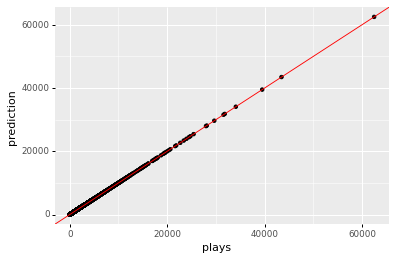

<ggplot: (8746516860968)>

In [20]:
train_results = train_preds.select('plays', 'prediction').toPandas()
( 
ggplot(train_results, aes(x='plays', y='prediction')) + 
    geom_point() + 
    geom_abline(slope=1, intercept=0, colour='red')
)

Vamos a probar qué tal funciona nuestro modelo con un usuario cualquiera. Para ello tenemos que usar la función recommendForAllUsers y filtraremos más tarde para un único usuario.

In [21]:
userRecs = trained_pipeline.stages[-1].bestModel.recommendForAllUsers(20)
userRecs.show()

/home/mdsuser/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
22/06/05 15:42:17 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB


+--------+--------------------+
|user_idx|     recommendations|
+--------+--------------------+
|      28|[{2165, 5602.7637...|
|      44|[{94, 23966.338},...|
|      53|[{2014, 139.71896...|
|      78|[{1936, 519.71295...|
|      85|[{2384, 5911.579}...|
|     255|[{2165, 1089.654}...|
|     271|[{2386, 18532.088...|
|     296|[{1936, 1390.8171...|
|     321|[{1404, 1752.3507...|
|     322|[{2386, 2255.492}...|
|     362|[{2386, 904.0799}...|
|     472|[{1870, 1243.4287...|
|     497|[{2165, 6631.1304...|
|     588|[{2386, 8228.434}...|
|     723|[{1803, 844.35706...|
|     731|[{3457, 10471.531...|
|     830|[{2384, 1085.369}...|
|     847|[{1404, 6036.1284...|
|     908|[{2386, 1200.254}...|
|     914|[{1404, 2019.3134...|
+--------+--------------------+
only showing top 20 rows



Tenemos un problema al haber utilizado StringIndexer ya que no tendemos los ids originales en el resultado de la función. Para ello con las posibles combinaciones de ids e idxs crearemos dos dataframes, uno para usuarios y otro para artistas.

In [22]:
user_label = train_preds.select(['user_id', 'user_idx']).distinct()

In [23]:
artist_label = train_preds.select(['artist_id', 'artist_idx']).distinct()

Uniremos estos dataframes con la tabla original para tener por cada fila el idxs de los usuarios y artistas.

In [24]:
plays_aux = plays.join(user_label, 'user_id')
plays_aux = plays_aux.join(artist_label, 'artist_id')
plays_aux.show()

22/06/05 15:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB
22/06/05 15:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
22/06/05 15:42:53 WARN DAGScheduler: Broadcasting large task binary with size 1017.1 KiB


+--------------------+--------------------+------------------+------+--------+----------+
|           artist_id|             user_id|       artist_name| plays|user_idx|artist_idx|
+--------------------+--------------------+------------------+------+--------+----------+
|a74b1b7f-71a5-401...|16aeda688419a1db6...|         radiohead| 385.0|  4120.0|       0.0|
|a74b1b7f-71a5-401...|542bb9a086129a85a...|         radiohead|3398.0|   225.0|       0.0|
|382f1005-e9ab-468...|8358173502fcfd30b...|              2pac|  54.0|  2268.0|     262.0|
|a74b1b7f-71a5-401...|78abffdc8a97490cc...|         radiohead| 116.0|   603.0|       0.0|
|a74b1b7f-71a5-401...|8358173502fcfd30b...|         radiohead|  75.0|  2268.0|       0.0|
|61386f55-12b6-45b...|b49b3cbba7d51ce94...|the appleseed cast|1937.0|  2776.0|    1216.0|
|a74b1b7f-71a5-401...|00189df758cfdbbed...|         radiohead|  38.0|  9505.0|       0.0|
|a74b1b7f-71a5-401...|2071ba8ca2d170ced...|         radiohead| 102.0|  8298.0|       0.0|
|a74b1b7f-

22/06/05 15:42:56 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB


Para tener únicamente un dataframe con los idxs de los artistas y su nombre:

In [25]:
artist_name = plays_aux.select(['artist_name', 'artist_idx']).distinct()

Vamos a ver los artistas más escuchados de un ususario para compararlo con sus recomendaciones:

In [26]:
plays_aux.where(plays_aux.user_idx == 10).select(['artist_name', 'plays']).orderBy(F.desc('plays')).show()

22/06/05 15:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1021.2 KiB
22/06/05 15:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
22/06/05 15:43:14 WARN DAGScheduler: Broadcasting large task binary with size 1016.7 KiB
22/06/05 15:43:16 WARN DAGScheduler: Broadcasting large task binary with size 1016.9 KiB


+------------------+------+
|       artist_name| plays|
+------------------+------+
|       the beatles|3701.0|
|   håkan hellström|3688.0|
|        mando diao|3647.0|
|    the libertines|2721.0|
|    arctic monkeys|1967.0|
|      babyshambles|1472.0|
|       the strokes|1235.0|
|         bob dylan|1195.0|
|       the killers|1031.0|
|        the smiths| 975.0|
|       jens lekman| 925.0|
|the rolling stones| 870.0|
|         the hives| 854.0|
|          johnossi| 690.0|
|              mgmt| 681.0|
|   shout out louds| 675.0|
|   franz ferdinand| 665.0|
|   françoise hardy| 516.0|
|              kent| 405.0|
|      joy division| 364.0|
+------------------+------+
only showing top 20 rows



Ahora mostramos sus recomendaciones:

In [27]:
(
    userRecs
    .filter(""" user_idx = 10 """)
    .withColumn("recommendations", F.explode("recommendations"))
    .withColumn("artist_idx", F.col('recommendations')['artist_idx'])
    .withColumn("rating", F.col('recommendations')['rating'])
    .drop("recommendations")
    .join(plays_aux, ['user_idx', 'artist_idx'], 'left_anti')
    .join(artist_name, 'artist_idx')
    .orderBy(F.desc('rating'))
    
).toPandas()

22/06/05 15:43:17 WARN DAGScheduler: Broadcasting large task binary with size 1021.0 KiB
22/06/05 15:43:21 WARN DAGScheduler: Broadcasting large task binary with size 1005.0 KiB
22/06/05 15:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1021.3 KiB
22/06/05 15:43:45 WARN DAGScheduler: Broadcasting large task binary with size 1021.4 KiB
22/06/05 15:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1025.8 KiB
22/06/05 15:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1017.9 KiB
22/06/05 15:43:53 WARN DAGScheduler: Broadcasting large task binary with size 1017.0 KiB
22/06/05 15:43:54 WARN DAGScheduler: Broadcasting large task binary with size 1052.1 KiB
22/06/05 15:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1099.3 KiB
22/06/05 15:43:55 WARN DAGScheduler: Broadcasting large task binary with size 1099.7 KiB
22/06/05 15:43:56 WARN DAGScheduler: Broadcasting large task binary with size 1096.2 KiB


,artist_idx,user_idx,rating,artist_name
0,1870,10,7815.065430,동방신기
1,2384,10,7400.369141,kat-tun
2,2386,10,5439.932617,meg & dia
3,2867,10,5242.465332,Владимир Высоцкий
4,1404,10,5006.159668,ガゼット
5,3428,10,4473.987305,buono!
6,3457,10,3804.398438,ayabie
7,834,10,3543.955078,dope
8,2660,10,3517.024414,los hermanos
9,419,10,3477.916992,scooter


Viendo los resultados de sus canciones más escuchadas podemos ver que a este usuario le gusta bastante el rock de habla inglesa. Sin embargo, en las recomendaciones nos aparece bastante artista asiático que realizando una búsqueda en Internet parece apuntar más al pop. Habría que estudiar si nuestro recomendador es todo lo bueno posible.

In [28]:
spark.stop()